# Financial Analysis Using Python

1. Population and Sample
2. Parameters and Statistics
3. Variation of Sample
4. Empirical Distribution of Mean
5. Sampling from Arbritary Distribution
6. Estimate the Average Stock Return with 90% Confidence Interval
7. Hypothesis Testing
8. Association between Two Random Variables
9. Simple Linear Regression
10. Least Sqaure Estimates
11. Model Diagnostics
-----
Signal Based Trading Strategy
12. Multiple Linear Regression Model
13. Evaluating the Strategy built from Regression Model
14. Evaluation of model - Practical Standard

# Buy-and-Hold versus Signal Based Trading Strategy
## 12. Multiple Linear Regression Model
### Building trading model of SPY based on the historical data of different stock markets 

SPY (SPDR -- Standard & Poor's Depositary Receipts) is designed to track the S&P 500 stock market index. 

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Import all stock market data into DataFrame

In [3]:
aord = pd.DataFrame.from_csv('ALLOrdinary.csv')
nikkei = pd.DataFrame.from_csv('Nikkei225.csv')
hsi = pd.DataFrame.from_csv('HSI.csv')
daxi = pd.DataFrame.from_csv('DAXI.csv')
cac40 = pd.DataFrame.from_csv('CAC40.csv')
sp500 = pd.DataFrame.from_csv('SP500.csv')
dji = pd.DataFrame.from_csv('DJI.csv')
nasdaq = pd.DataFrame.from_csv('nasdaq_composite.csv')
spy = pd.DataFrame.from_csv('SPY.csv')

In [4]:
nasdaq.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,2653.909912,2661.500000,2597.810059,2609.629883,2609.629883,2076690000
2008-01-03,2611.959961,2624.270020,2592.179932,2602.679932,2602.679932,1970200000
2008-01-04,2571.080078,2571.080078,2502.679932,2504.649902,2504.649902,2516310000
2008-01-07,2514.149902,2521.620117,2471.229980,2499.459961,2499.459961,2600100000
2008-01-08,2506.969971,2527.419922,2440.510010,2440.510010,2440.510010,2566480000


### Step 1: Data Munging

In [5]:
# Due to the timezone issues (location), we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model

indicepanel=pd.DataFrame(index=spy.index)

indicepanel['spy']=spy['Open'].shift(-1)-spy['Open']
indicepanel['spy_lag1']=indicepanel['spy'].shift(1)
indicepanel['sp500']=sp500["Open"]-sp500['Open'].shift(1)
indicepanel['nasdaq']=nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji']=dji['Open']-dji['Open'].shift(1)

indicepanel['cac40']=cac40['Open']-cac40['Open'].shift(1)
indicepanel['daxi']=daxi['Open']-daxi['Open'].shift(1)

indicepanel['aord']=aord['Close']-aord['Open']
indicepanel['hsi']=hsi['Close']-hsi['Open']
indicepanel['nikkei']=nikkei['Close']-nikkei['Open']
indicepanel['Price']=spy['Open']

In [6]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-02,-1.619995,NaN,NaN,NaN,NaN,NaN,NaN,-50.100097,-71.679688,NaN,146.529999
2008-01-03,-1.570008,-1.619995,-20.419922,-41.949951,-217.70019,-71.779785,-104.450195,-2.300293,-162.750000,NaN,144.910004
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,NaN,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002


#### Impute NaN Values

In [7]:
# Lets check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        1
dji           1
cac40        30
daxi         53
aord        319
hsi         121
nikkei      145
Price         0
dtype: int64

In [8]:
# We can use method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [9]:
# Lets check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [10]:
print(indicepanel.shape)

(2677, 11)


### Step 2: Data Spliting

In [11]:
#split the data into (1)train set and (2)test set

Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


### Step 3: Explore the Train Dataset

In [12]:
Test.describe()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.085550,0.085280,0.857440,3.247670,8.689570,0.841760,2.143367,0.754303,-16.697033,-5.218715,227.029970
std,1.738165,1.738093,17.006346,56.816442,154.915940,50.436480,125.869037,43.003172,206.375273,169.664760,27.349764
min,-13.510010,-13.510010,-126.280030,-449.430176,-1252.699220,-290.100098,-884.849610,-204.399903,-1055.150390,-1381.850586,182.339996
25%,-0.682491,-0.682491,-6.777466,-21.072510,-57.920905,-25.594971,-62.197510,-24.049927,-118.809082,-78.603515,206.455006
50%,0.140007,0.140007,1.414978,6.565186,12.775390,4.205078,7.090332,2.399902,-6.099609,-2.950195,215.389999
75%,0.952496,0.952496,9.452453,32.614868,84.279782,29.464966,69.457763,27.299926,96.930664,80.102051,247.287499
max,8.799988,8.799988,76.169922,335.660157,807.699220,226.939942,528.150391,170.600097,957.289063,1012.378907,286.250000


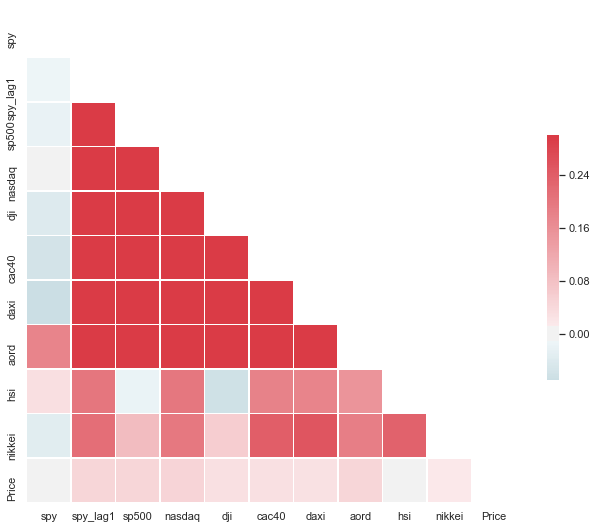

In [13]:
# Generate diagonal correlation matrix among all stock markets (and the price of SPY) to observe the association

#from pandas.tools.plotting import scatter_matrix
from string import ascii_letters
import seaborn as sns

sns.set(style="white")


corr = Train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Step 4: Check the Correlation of each Index between spy

In [14]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.011623
sp500      -0.018632
nasdaq      0.012333
dji        -0.037097
cac40      -0.055304
daxi       -0.069735
aord        0.179638
hsi         0.031400
nikkei     -0.035048
Name: spy, dtype: float64


In [15]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.962
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           1.97e-11
Time:                        20:10:45   Log-Likelihood:                -1617.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     990   BIC:                             3305.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.039      2.138      0.033       0.007       0.160
spy_lag1      -0.1567      0.091     -1.730      0.084      -0.335       0.021
sp500          0.0221      0.014      1.621      0.105      -0.005       0.049
nasdaq         0.0040      0.004      1.066      0.287      -0.003       0.011
dji           -0.0018      0.001     -1.248      0.212      -0.005       0.001
cac40         -0.0003      0.002     -0.153      0.879      -0.004       0.004
aord           0.0093      0.001      7.492      0.000       0.007       0.012
daxi          -0.0025      0.001     -2.387      0.017      -0.005      -0.000
nikkei        -0.0004      0.000     -1.264      0.207      -0.001       0.000
hsi            0.0003      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                       91.018   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.687
Skew:                          -0.450   Prob(JB):                     7.45e-59
Kurtosis:                       5.369   Cond. No.                         405.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 5: Make Predictions

In [16]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

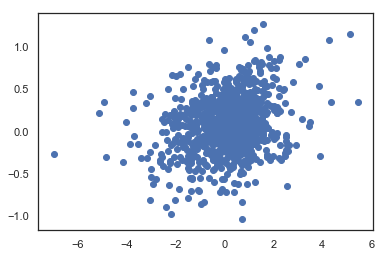

In [17]:
plt.scatter(Train['spy'], Train['PredictedY'])

### Step 6: Model Evaluation - Statistical Standard

We can measure the performance of our model using some statistical metrics - RMSE, Adjusted  R2

In [18]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [19]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [20]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'spy')

,Train,Test
R2,0.059020,0.067248
RMSE,1.226068,1.701291


## 13. Evaluating the Strategy built from Regression Model

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
indicepanel = pd.DataFrame.from_csv('indicepanel.csv')
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,-2.300293,515.349609,-464.320313,143.339996
2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002
2008-01-09,0.589997,-2.990006,-25.459961,-63.119873,-230.69043,-17.109864,-5.270020,-12.900390,768.359375,234.450195,139.089996
2008-01-10,1.100006,0.589997,16.530029,8.270019,142.90039,9.140137,-40.120117,-100.200196,-195.560547,-158.209961,139.679993


In [23]:
Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]

In [24]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()

In [25]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

### Profit of Signal-based Strategy

In [26]:
# Train
Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['spy'] * Train['Order']

Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())

Total profit made in Train:  214.34009500000042


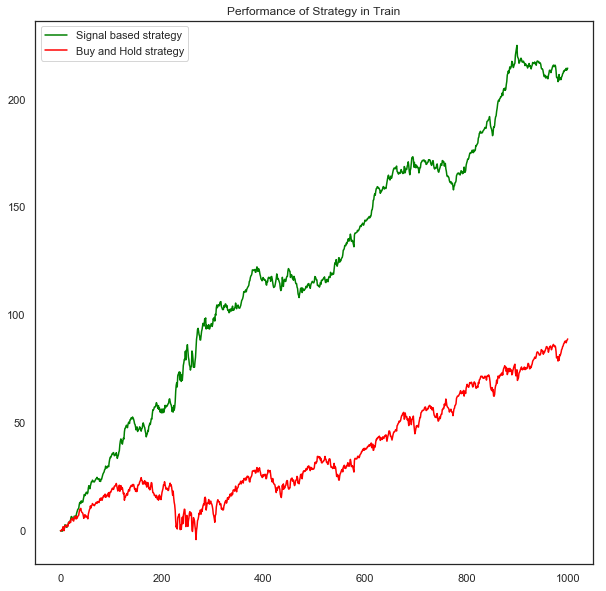

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [28]:
# Test
Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']

Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  241.0300879999996


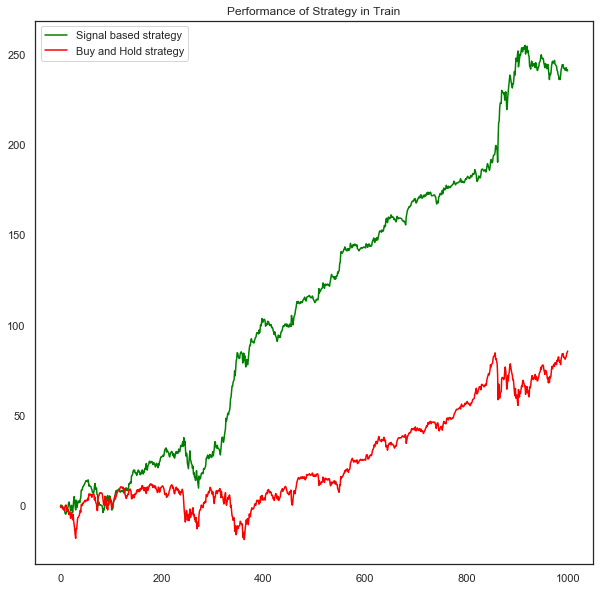

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

## 14. Evaluation of Model - Practical Standards

#### introduce two common practical standards - Sharpe Ratio, Maximum Drawdown to evaluate our model performance

Sharpe Ratio: a measure that indicates the average return minus the risk-free return divided by the standard deviation of return on an investment. 

- The risk adjusted return. The greater a portfolio's Sharpe ratio, the better its risk-adjusted performance.

Maximum drawdown: the maximum loss from a peak to a trough of a portfolio, before a new peak is attained. Maximum Drawdown (MDD) is an indicator of downside risk over a specified time period.

- A low maximum drawdown is preferred as this indicates that losses from investment were small.

In [30]:
Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

In [31]:
# Sharpe Ratio on Train data
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.179650763032581
Yearly Sharpe Ratio is  2.851867450963232


In [32]:
# Sharpe Ratio in Test data
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.13035126208575035
Yearly Sharpe Ratio is  2.0692621353737883


In [33]:
# Maximum Drawdown in Train data
Train['Peak'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

Maximum Drawdown in Train is  0.06069016443644382


In [34]:
# Maximum Drawdown in Test data
Test['Peak'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Maximum Drawdown in Test is  0.11719899524631659
